# Linear Regression Project

## Combined Cycle Power Plant <br>

Author: Piotr Druzdzel <br>
E-mail: piotr.druzdzel@gmail.com <br> <br>

Data source: UCI Machine Learning Repository <br>
https://archive.ics.uci.edu/ml/datasets/Combined+Cycle+Power+Plant

#### Data Set Information: 
The dataset contains 9568 data points collected from a Combined Cycle Power Plant over 6 years (2006-2011), when the power plant was set to work with full load. <br>

#### Attribute Information:

Features consist of hourly average ambient variables <br>
- Ambient Temperature (AT) in the range 1.81°C and 37.11°C <br>
- Ambient Pressure (AP) in the range 992.89-1033.30 milibar <br>
- Relative Humidity (RH) in the range 25.56% to 100.16% <br>
- Exhaust Vacuum (V) in the range 25.36-81.56 cm Hg <br>
- Net hourly electrical energy output (PE) 420.26-495.76 MW <br>

The averages are taken from various sensors located around the plant that record the ambient variables every second. <br>
The variables are given without normalization.

Basic libraries:

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import sklearn as sk

Quick fix for the dark theme plotting to have readable labels:

In [2]:
from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

## Importing the data:

Parsing the Excel file to variable xls to extract all the sheets:

In [3]:
xls = pd.ExcelFile("Folds5x2_pp.xlsx")

Saving each sheet to a separate dataframe:

In [4]:
df1 = pd.read_excel(xls, 'Sheet1')
df2 = pd.read_excel(xls, 'Sheet2')
df3 = pd.read_excel(xls, 'Sheet3')
df4 = pd.read_excel(xls, 'Sheet4')
df5 = pd.read_excel(xls, 'Sheet5')

Concatenating all sheets ignoring old indices (0 - 9,567) and making a new DataFrame of indices (0 - 47,839).

In [5]:
df_original = pd.concat([df1, df2, df3, df4, df5], ignore_index=True)

In [6]:
df_original.rename(columns={'AT':'Temp', 
                            'V':'Vac',
                            'AP':'Press',
                            'RH':'Humid',
                            'PE':'Power'},
                             inplace=True)

Keeping fully concatenated DataFrame separately as a backup due to computational time reasons:

In [7]:
df = df_original.copy()

Data Frame check:

In [8]:
#2006
df = df.iloc[:9568,:]

#2006, 2007, 2008
#df = df.iloc[:28704,:]

df

,Temp,Vac,Press,Humid,Power
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90
...,...,...,...,...,...
9563,16.65,49.69,1014.01,91.00,460.03
9564,13.19,39.18,1023.67,66.78,469.62
9565,31.32,74.33,1012.92,36.48,429.57
9566,24.48,69.45,1013.86,62.39,435.74


## Basic dataset exploration:

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9568 entries, 0 to 9567
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Temp    9568 non-null   float64
 1   Vac     9568 non-null   float64
 2   Press   9568 non-null   float64
 3   Humid   9568 non-null   float64
 4   Power   9568 non-null   float64
dtypes: float64(5)
memory usage: 373.9 KB


Checking for missing values:

In [10]:
df.isnull().sum()

Temp     0
Vac      0
Press    0
Humid    0
Power    0
dtype: int64

Basic statistics:

In [11]:
df.describe()

,Temp,Vac,Press,Humid,Power
count,9568.000000,9568.000000,9568.000000,9568.000000,9568.000000
mean,19.651231,54.305804,1013.259078,73.308978,454.365009
std,7.452473,12.707893,5.938784,14.600269,17.066995
min,1.810000,25.360000,992.890000,25.560000,420.260000
25%,13.510000,41.740000,1009.100000,63.327500,439.750000
50%,20.345000,52.080000,1012.940000,74.975000,451.550000
75%,25.720000,66.540000,1017.260000,84.830000,468.430000
max,37.110000,81.560000,1033.300000,100.160000,495.760000


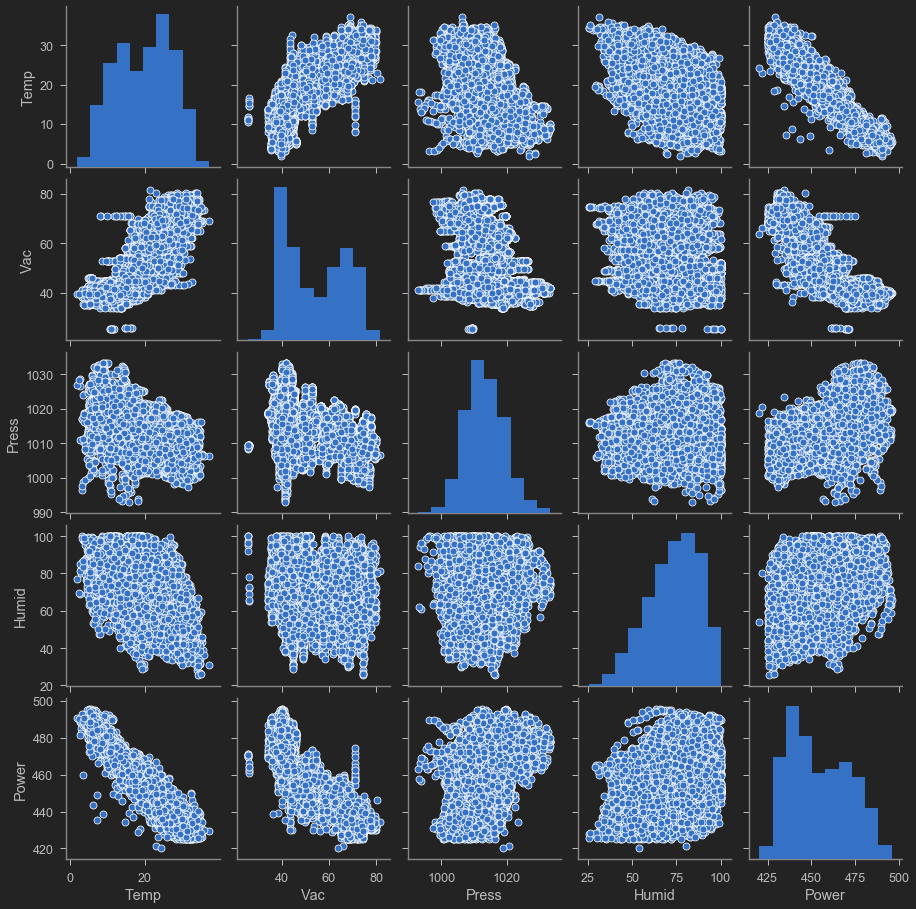

In [12]:
sns.pairplot(df);

Checking for correlations:

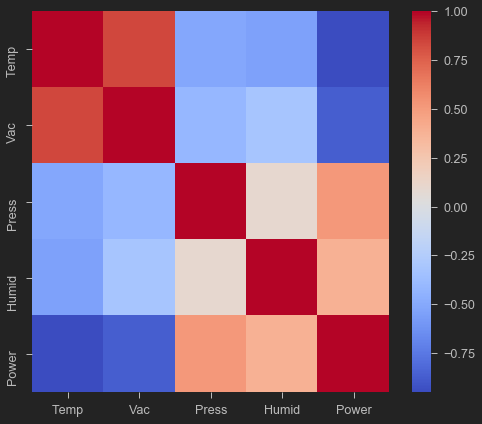

In [13]:
sns.heatmap(df.corr(), cmap='coolwarm')

Ambient Temperature vs Power Output (quite consistent inverse correlation - thermodynamics):

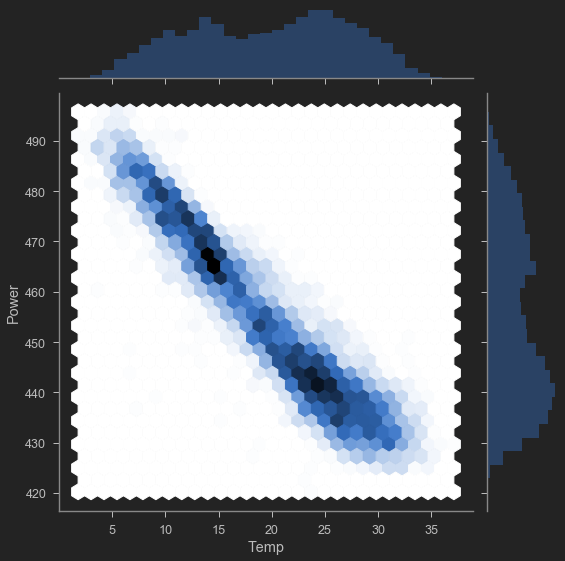

In [14]:
sns.jointplot(df['Temp'], df['Power'], kind='hex', height=8);

## Violin plots - already can be concluded from the pairplot - added just for clarity:

### Violin plot - Temperature

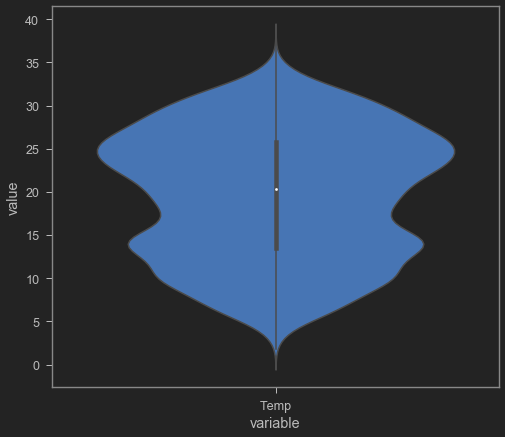

In [15]:
sns.violinplot(x="variable", y="value", data=pd.melt(df[['Temp']]));

### Violin plot - Power Output

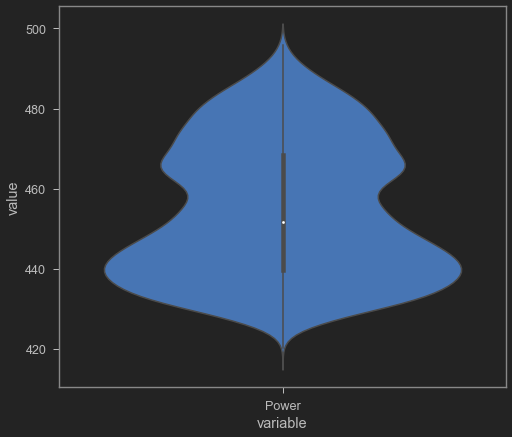

In [16]:
sns.violinplot(x="variable", y="value", data=pd.melt(df[['Power']]))

## Train-Test set split

In [17]:
from sklearn.model_selection import train_test_split

y = df['Power']
X = df.drop(['Power'], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

## Scaling the data
Not a must in linear regression due to coefficients accounting for scale of numbers but helps in interpretation.

In [18]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Model selection:

In [19]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn import model_selection
from sklearn.metrics import r2_score

accuracies = []
R2_scores = []
    
models = [('MLR', LinearRegression()),
          ('SVR', SVR()),
          ('DT', DecisionTreeRegressor()),
          ('RF', RandomForestRegressor(n_estimators=10)),
          ('XGB', XGBRegressor())]
    
for name, model in models:
    
    print(f'Current model: {model} \n')
    
    model.fit(X_train, y_train)
    accuracy_results = model_selection.cross_val_score(model, X_train, y_train, cv=10)
    
    prediction_model = model.predict(X_test)
    R2_score = r2_score(y_test, prediction_model)
    
    accuracies.append(accuracy_results)
    R2_scores.append(R2_score)

Current model: LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False) 

Current model: SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False) 

Current model: DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best') 

Current model: RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                    

## R2 scores:

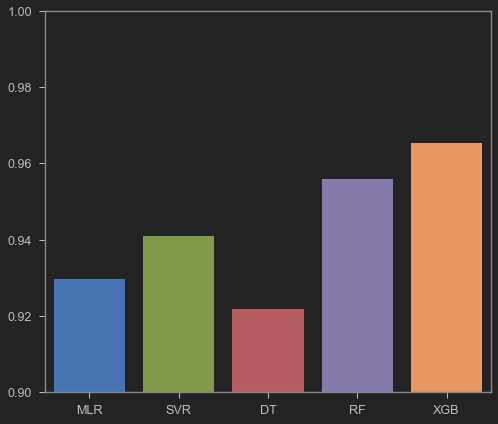

In [20]:
r2_series = pd.Series(R2_scores)

ax = sns.barplot(r2_series.index, r2_series.values)
ax.set(ylim=(0.90, 1))
ax.set_xticklabels(["MLR","SVR",'DT','RF', 'XGB']);

## Box plot

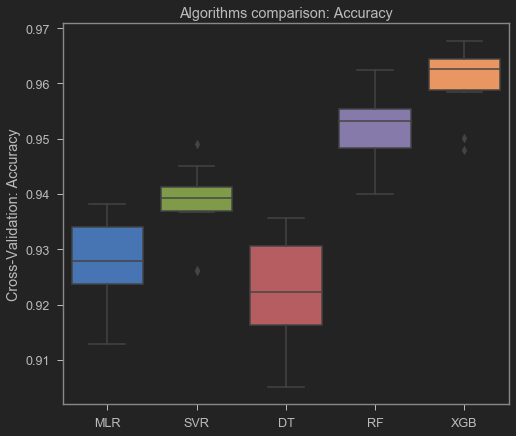

In [21]:
accuracies_df = pd.DataFrame(np.transpose(accuracies), columns=['MLR','SVR','DT','RF', 'XGB'])

ax = sns.boxplot(data=accuracies_df)
ax.set_title('Algorithms comparison: Accuracy')
ax.set_ylabel('Cross-Validation: Accuracy');

In [22]:
mean_accuracies = [result.mean() for result in accuracies]
mean_accuracies

[0.9277154559488789,
 0.9381433438681996,
 0.9227107800176482,
 0.952026997127132,
 0.9604463259047733]

# All models separately:

## Multiple Linear Regression

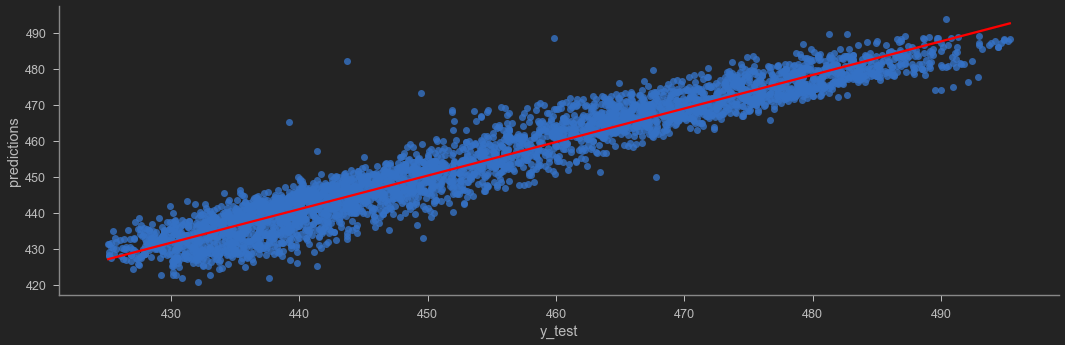

In [23]:
from sklearn.linear_model import LinearRegression
from sklearn import model_selection

model_LR = LinearRegression()
model_LR.fit(X_train, y_train)
predictions_LR = model_LR.predict(X_test)

accuracy_LR = model_selection.cross_val_score(model_LR, X_train, y_train, cv=10) #Evaluate a score by cross-validation

pred_df = pd.DataFrame({'y_test':y_test, 'predictions':predictions_LR})
sns.lmplot(x='y_test', 
           y='predictions', 
           data=pred_df,
           height=5, 
           aspect=3,
           line_kws={'color': 'red'});

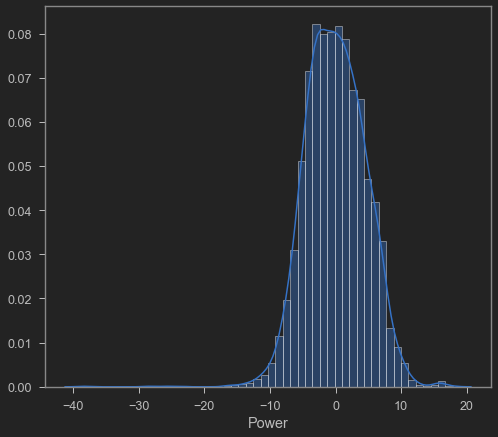

In [24]:
sns.distplot((y_test-predictions_LR),
              bins=50,
              hist_kws=dict(edgecolor="w", linewidth=1));

## Polynomial Regression

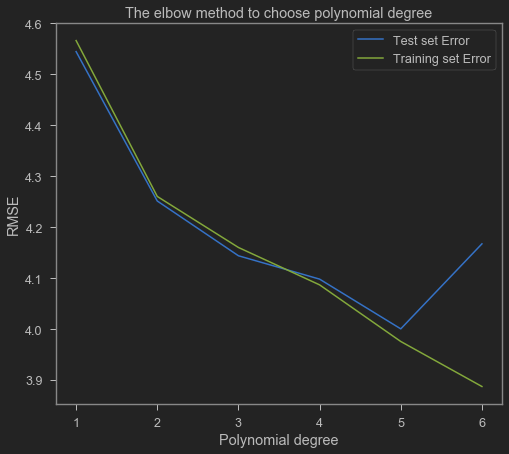

In [25]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn import metrics

RMSE_score = []   #RMSE between the predicted values and the test set
training_fit = [] #RMSE between the predicted values and the training set on which the data was trained (just to check)

degrees = range(1,7)

for deg in degrees:
    
    #Polynomial features:
    poly_features = PolynomialFeatures(degree=deg)
    X_poly_train = poly_features.fit_transform(X_train)
    X_poly_test  = poly_features.fit_transform(X_test)
    
    #Model training:
    poly_model = LinearRegression()
    poly_model.fit(X_poly_train, y_train)
    
    #Predictions on Test set:
    predictions_poly = poly_model.predict(X_poly_test)
    RMSE_poly = np.sqrt(metrics.mean_squared_error(y_test, predictions_poly)) 
    
    #Predictions on Training set (just to check):
    predictions_train = poly_model.predict(X_poly_train)                        # not paramount, just to check
    fit_poly =  np.sqrt(metrics.mean_squared_error(y_train, predictions_train)) # not paramount, just to check
    
    #Append lists:
    RMSE_score.append(RMSE_poly)
    training_fit.append(fit_poly) # not paramount, just to see

#Plot curves to decide on optimum:
plt.plot(degrees, RMSE_score, label='Test set Error')
plt.plot(degrees, training_fit, label='Training set Error')

plt.title('The elbow method to choose polynomial degree')
plt.xlabel('Polynomial degree')
plt.ylabel('RMSE')
plt.legend()
plt.show()

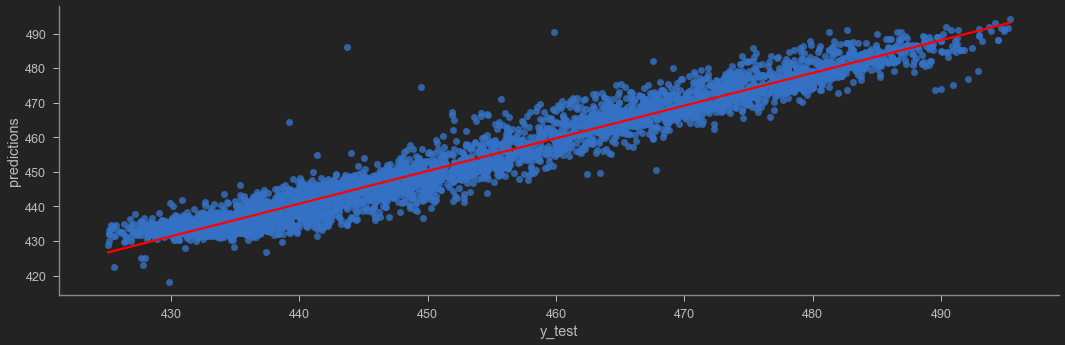

In [26]:
poly_features = PolynomialFeatures(degree=5)
X_poly_train = poly_features.fit_transform(X_train)
X_poly_test  = poly_features.fit_transform(X_test)

model_poly = LinearRegression()
model_poly.fit(X_poly_train, y_train)
predictions_poly = model_poly.predict(X_poly_test)

accuracy_poly = model_selection.cross_val_score(model_poly, X_poly_train, y_train, cv=10) #Evaluate a score by cross-validation

pred_poly_df = pd.DataFrame({'y_test':y_test, 'predictions':predictions_poly})
sns.lmplot(x='y_test', 
           y='predictions', 
           data=pred_poly_df, 
           height=5, 
           aspect=3,
           line_kws={'color': 'red'});

## Boxplot with polynomial regression:

In [27]:
accuracy_df = pd.DataFrame({'Poly': accuracy_poly}) #making DataFrame from np.array of 10 poly accuracies
accuracies_df = accuracies_df.join(accuracy_df) #joining two DataFrames

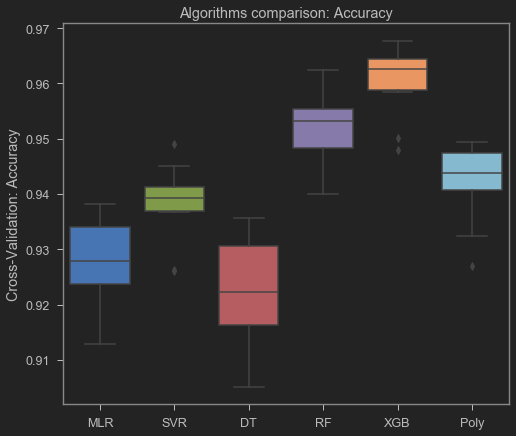

In [28]:
ax = sns.boxplot(data=accuracies_df)
ax.set_title('Algorithms comparison: Accuracy')
ax.set_ylabel('Cross-Validation: Accuracy');

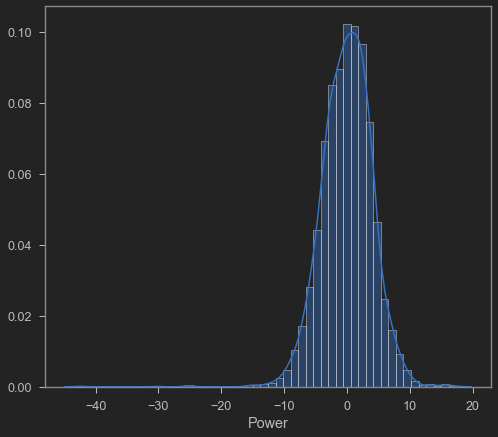

In [29]:
sns.distplot((y_test-predictions_poly),
              bins=50,
              hist_kws=dict(edgecolor="w", linewidth=1));

## SVR

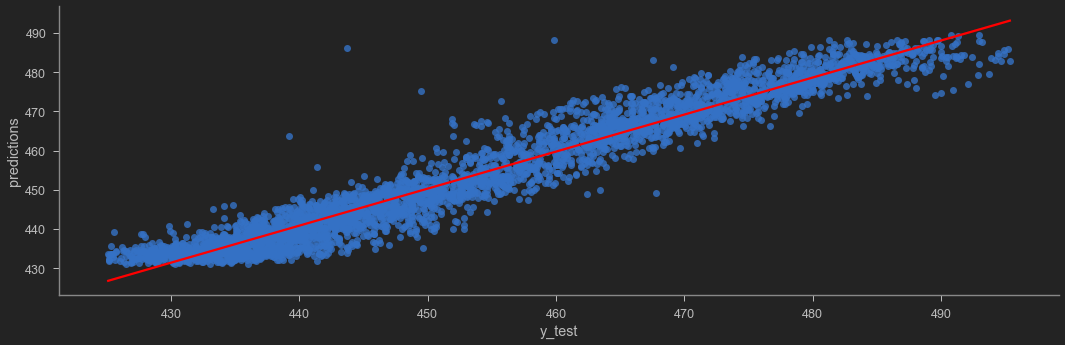

In [30]:
from sklearn.svm import SVR

model_SVR = SVR()
model_SVR.fit(X_train, y_train)
predictions_SVR = model_SVR.predict(X_test)

accuracy_SVR = model_selection.cross_val_score(model_SVR, X_train, y_train, cv=10) #Evaluate a score by cross-validation

pred_df = pd.DataFrame({'y_test':y_test, 'predictions':predictions_SVR})
sns.lmplot(x='y_test', 
           y='predictions', 
           data=pred_df,
           height=5, 
           aspect=3,
           line_kws={'color': 'red'});

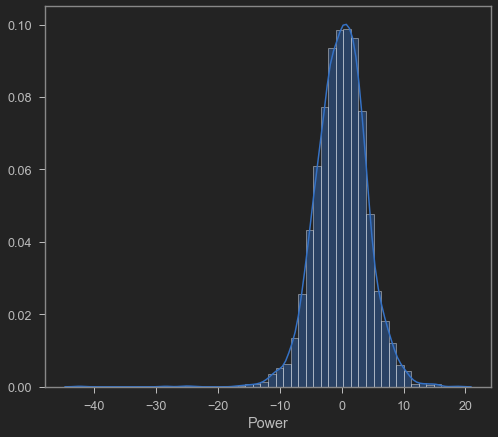

In [31]:
sns.distplot((y_test-predictions_SVR),
              bins=50,
              hist_kws=dict(edgecolor="w", linewidth=1));

## Decision Tree:

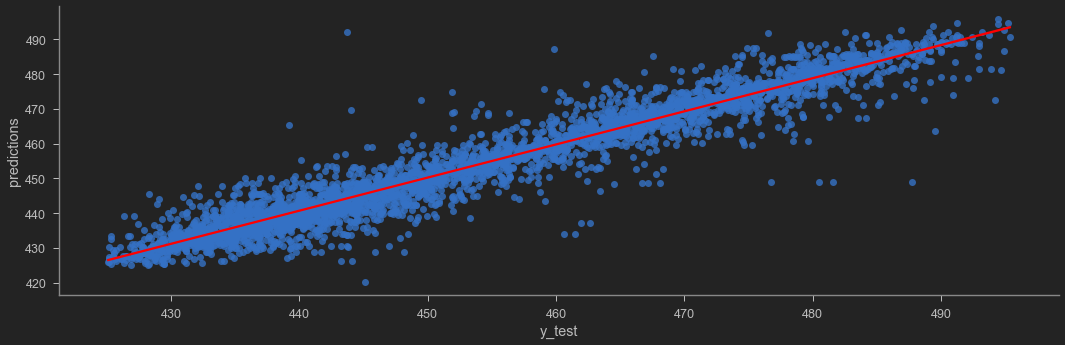

In [32]:
from sklearn.tree import DecisionTreeRegressor

model_DT = DecisionTreeRegressor()
model_DT.fit(X_train, y_train)
predictions_DT = model_DT.predict(X_test)

accuracy_DT = model_selection.cross_val_score(model_DT, X_train, y_train, cv=10) #Evaluate a score by cross-validation

pred_df = pd.DataFrame({'y_test':y_test, 'predictions':predictions_DT})
sns.lmplot(x='y_test', 
           y='predictions', 
           data=pred_df,
           height=5, 
           aspect=3,
           line_kws={'color': 'red'});

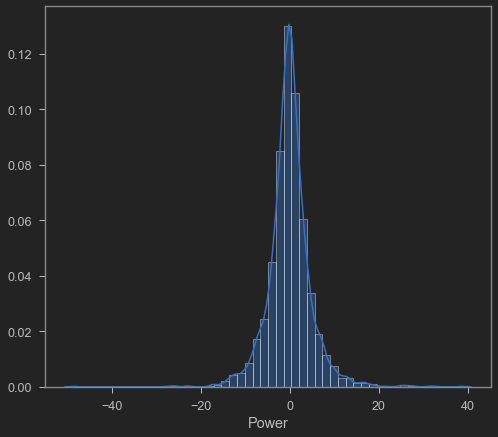

In [33]:
sns.distplot((y_test-predictions_DT),
              bins=50,
              hist_kws=dict(edgecolor="w", linewidth=1));

## Random Forest:

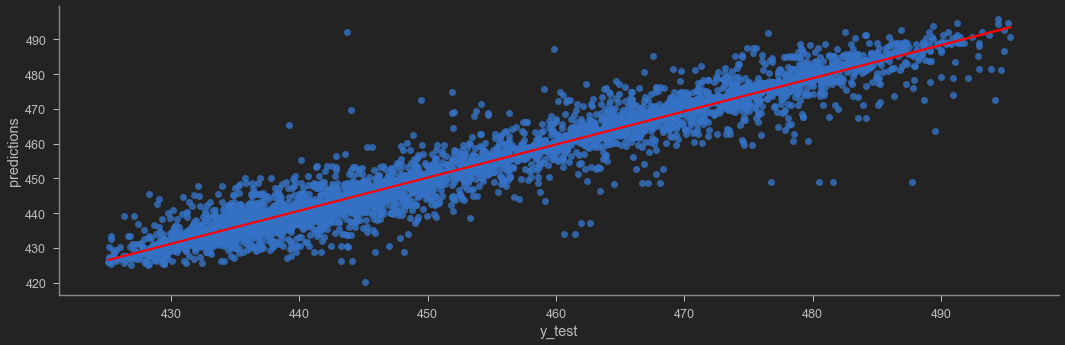

In [34]:
from sklearn.ensemble import RandomForestRegressor

model_RF = RandomForestRegressor(n_estimators=10)
model_RF.fit(X_train, y_train)
predictions_RF = model_DT.predict(X_test)

accuracy_RF = model_selection.cross_val_score(model_RF, X_train, y_train, cv=10) #Evaluate a score by cross-validation

pred_df = pd.DataFrame({'y_test':y_test, 'predictions':predictions_RF})
sns.lmplot(x='y_test', 
           y='predictions', 
           data=pred_df,
           height=5, 
           aspect=3,
           line_kws={'color': 'red'});

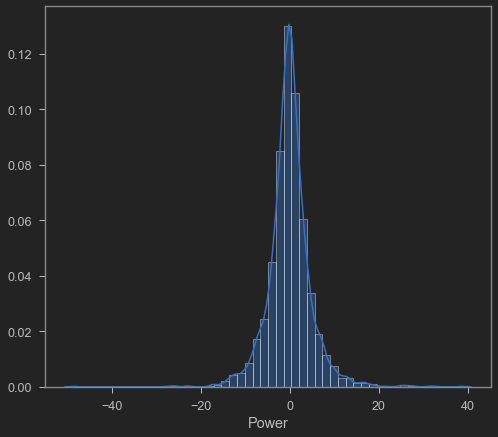

In [35]:
sns.distplot((y_test-predictions_RF),
              bins=50,
              hist_kws=dict(edgecolor="w", linewidth=1));

## XGBoost (eXtreme Gradient Boosting)

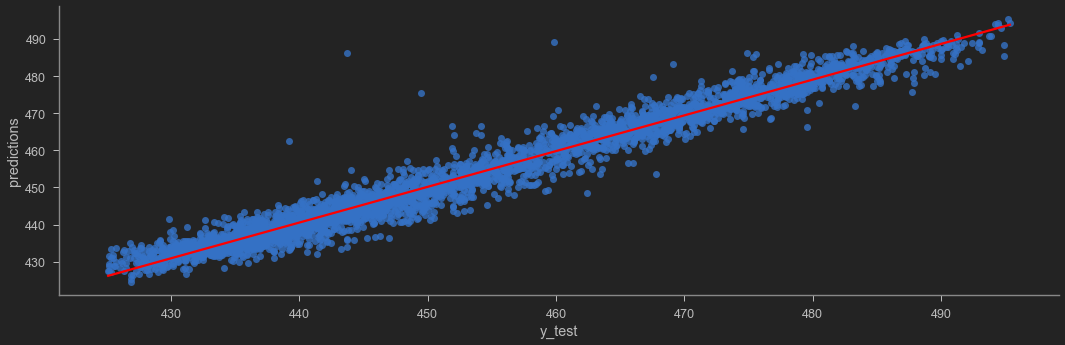

In [36]:
from xgboost import XGBRegressor

model_XGB = XGBRegressor()
model_XGB.fit(X_train, y_train)
predictions_XGB = model_XGB.predict(X_test)

accuracy_XGB = model_selection.cross_val_score(model_XGB, X_train, y_train, cv=10) #Evaluate a score by cross-validation

pred_df = pd.DataFrame({'y_test':y_test, 'predictions':predictions_XGB})
sns.lmplot(x='y_test', 
           y='predictions', 
           data=pred_df,
           height=5, 
           aspect=3,
           line_kws={'color': 'red'});

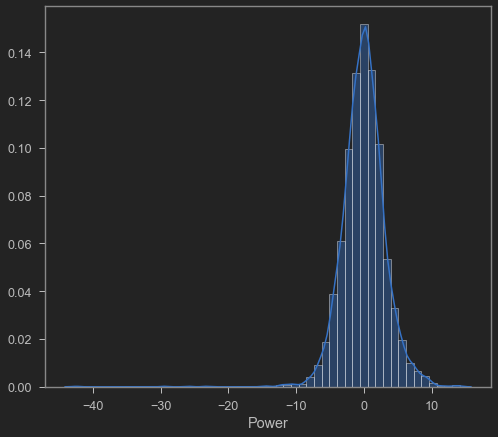

In [37]:
sns.distplot((y_test-predictions_XGB),
              bins=50,
              hist_kws=dict(edgecolor="w", linewidth=1));

In [38]:
r2_initial = accuracy_XGB.mean()
r2_initial

0.9604463259047733

## Evaluation:

95% of the results is within 6.4 [MW] from the actual Power Output (within 1.5% on the conservative side):

In [39]:
(y_test-predictions_XGB).std()*2 / df['Power'].min()*100

1.515587364427874

## Test vs Predicted values visualization:

In [40]:
results = pd.DataFrame({'Test': y_test.round(), 'Predictions': predictions_XGB.round()})
results.sort_index(inplace=True)
results

,Test,Predictions
0,463.0,463.0
3,446.0,446.0
8,476.0,471.0
10,453.0,456.0
12,440.0,438.0
...,...,...
9558,445.0,443.0
9561,465.0,464.0
9563,460.0,460.0
9566,436.0,438.0


Every 100th measurement, visual check:

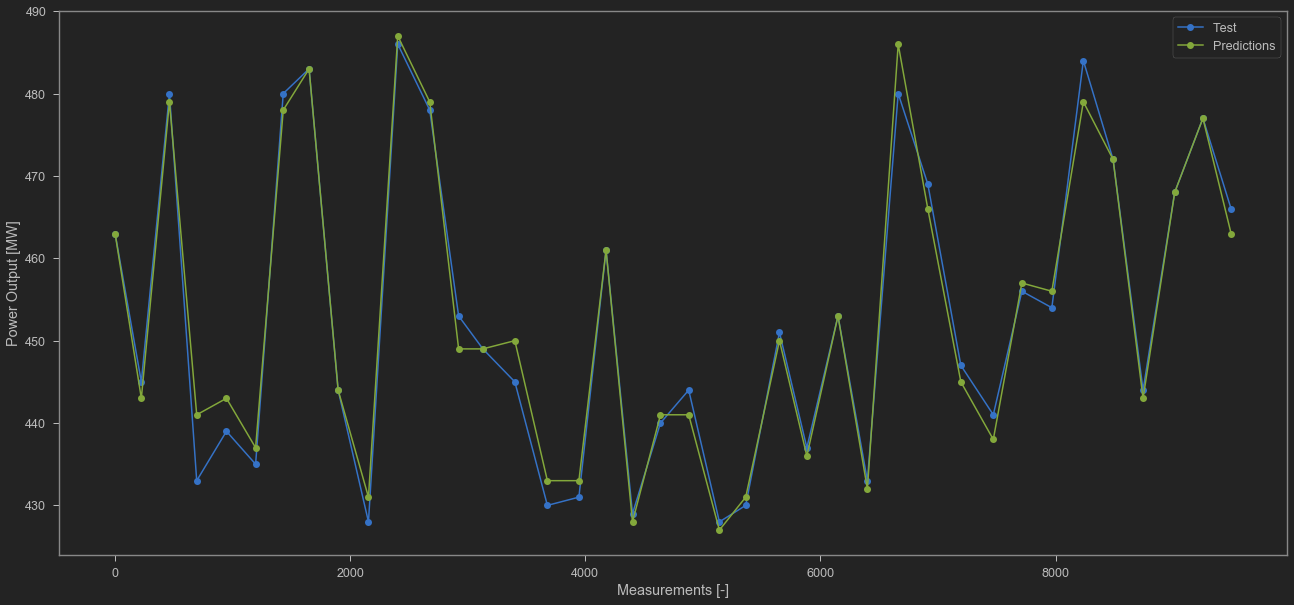

In [41]:
plt.figure(figsize=(22,10))
plt.plot(results.index[::100], results['Test'][::100], '-o', label='Test')
plt.plot(results.index[::100], results['Predictions'][::100], '-o', label='Predictions')
plt.xlabel('Measurements [-]')
plt.ylabel('Power Output [MW]')
plt.legend()
plt.show()

# Fine-tuning the XGB model:

In [42]:
# XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
#              colsample_bynode=None, colsample_bytree=None, gamma=None,
#              gpu_id=None, importance_type='gain', interaction_constraints=None,
#              learning_rate=None, max_delta_step=None, max_depth=None,
#              min_child_weight=None, missing=nan, monotone_constraints=None,
#              n_estimators=100, n_jobs=None, num_parallel_tree=None,
#              objective='reg:squarederror', random_state=None, reg_alpha=None,
#              reg_lambda=None, scale_pos_weight=None, subsample=None,
#              tree_method=None, validate_parameters=None, verbosity=None) 

Narrowing down the choices...

In [43]:
# from sklearn.model_selection import GridSearchCV

# parameters = [{'n_estimators':[1000],
#                'learning_rate':[0.05, 0.06, 0.7],
#                'max_depth':[6,7,8],
#                'gamma':[0.5,1,2]}]

# grid_search = GridSearchCV(estimator=model_XGB,
#                            param_grid=parameters,
#                            scoring='r2',
#                            cv=10,
#                            n_jobs=-1)

# grid_search.fit(X_train, y_train)

Final run:

In [44]:
from sklearn.model_selection import GridSearchCV

parameters = [{'n_estimators':[1000],
               'learning_rate':[0.05],
               'max_depth':[8,9],
               'gamma':[1]}]

grid_search = GridSearchCV(estimator=model_XGB,
                           param_grid=parameters,
                           scoring='r2',
                           cv=10,
                           n_jobs=-1)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0, gpu_id=-1,
                                    importance_type='gain',
                                    interaction_constraints='',
                                    learning_rate=0.300000012, max_delta_step=0,
                                    max_depth=6, min_child_weight=1,
                                    missing=nan, monotone_constraints='()',
                                    n_estimators=100, n_job...
                                    objective='reg:squarederror',
                                    random_state=0, reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, subsample=1,
                                    tree_method='exact', validate_parameters=1,
                                 

Best score

In [45]:
best_r2 = grid_search.best_score_
best_r2

0.9648640463375706

Best parameters:

In [46]:
best_parameters = grid_search.best_params_
best_parameters

{'gamma': 1, 'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 1000}

Fine-tuning improvement by 0.5% w.r.t. auto parameters: <br>
Side note: it was already a very high score to beat

In [48]:
(best_r2-r2_initial)/r2_initial*100

0.4599653633570484